In [3]:
import os
import json
import csv
import random
import pickle
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [4]:
#preprocessing for technique number 2 : Resize(256x256)+Crop+adjust Saturation
def preprocess_img(img):
    img=transforms.functional.adjust_saturation(img, 2)
    img=transforms.functional.crop(img, 500, 0, 1000, 1000)
    
    
def preprocess_seg(seg):
    seg=transforms.functional.crop(seg, 500, 0, 1000, 1000)

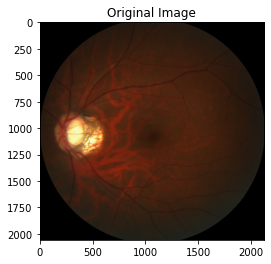

(1000, 1000, 3)


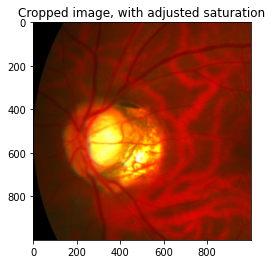

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
root_dir = '/content/drive/MyDrive/REFUGE'
img = mpimg.imread(root_dir+'/train/Images/g0006.jpg')
imgplot = plt.imshow(img)
plt.title('Original Image')
plt.show()

img2=Image.open(root_dir+'/train/Images/g0006.jpg').convert('RGB')
img2=transforms.functional.adjust_saturation(img2, 2)
img2=transforms.functional.crop(img2, 500, 0, 1000, 1000)
print(np.array(img2).shape)
imgplot = plt.imshow(img2)
plt.title('Cropped image, with adjusted saturation')
plt.show()

In [3]:
class RefugeDataset(Dataset):

    def __init__(self, root_dir, split='train', output_size=(256,256)):
        # Define attributes
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        
        # Load data index
        with open(os.path.join(self.root_dir, self.split, 'index.json')) as f:
            self.index = json.load(f)
            
        self.images = []
        for k in range(len(self.index)):
            print('Loading {} image {}/{}...'.format(split, k, len(self.index)), end='\r')
            img_name = os.path.join(self.root_dir, self.split, 'Images', self.index[str(k)]['ImgName'])
            img=Image.open(img_name).convert('RGB')
            ##preprocessing the images
            #preprocess_img(img)
            ###preprocessing the images
            img = np.array(img)

            img = transforms.functional.to_tensor(img)
            img = transforms.functional.resize(img, self.output_size, interpolation=Image.BILINEAR)
#            img=transforms.functional.normalize(img,(0.5, 0.5,0.5), (0.5, 0.5,0.5))
            self.images.append(img)
            
        # Load ground truth for 'train' and 'val' sets
        if split != 'test':
            self.segs = []
            for k in range(len(self.index)):
                print('Loading {} segmentation {}/{}...'.format(split, k, len(self.index)), end='\r')
                seg_name = os.path.join(self.root_dir, self.split, 'gts', self.index[str(k)]['ImgName'].split('.')[0]+'.bmp')
                seg=Image.open(seg_name)
                ###preprocessing the segmented images
                #preprocess_seg(seg)
                ###preprocessing the segmented images
                seg = np.array(seg).copy()
                seg = 255. - seg
                od = (seg>=127.).astype(np.float32)
                oc = (seg>=250.).astype(np.float32)
                od = torch.from_numpy(od[None,:,:])
                oc = torch.from_numpy(oc[None,:,:])
                
                od = transforms.functional.resize(od, self.output_size, interpolation=Image.NEAREST)
                oc = transforms.functional.resize(oc, self.output_size, interpolation=Image.NEAREST)
                seg = torch.cat([od, oc], dim=0)
 #               seg=transforms.functional.normalize(seg,(0.5, 0.5), (0.5, 0.5))
                self.segs.append(seg)
                
        print('Succesfully loaded {} dataset.'.format(split) + ' '*50)
            
            
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # Image
        img = self.images[idx]
    
        # Return only images for 'test' set
        if self.split == 'test':
            return img
        
        # Else, images and ground truth
        else:
            # Label
            lab = torch.tensor(self.index[str(idx)]['Label'], dtype=torch.float32)

            # Segmentation masks
            seg = self.segs[idx]

            # Fovea localization
            f_x = self.index[str(idx)]['Fovea_X']
            f_y = self.index[str(idx)]['Fovea_Y']
            fov = torch.FloatTensor([f_x, f_y])
        
            return img, lab, seg, fov, self.index[str(idx)]['ImgName']

In [4]:
def update(index,k,l):
    st=index[str(k)]
    st['ImgName']="r"+str(l)+st['ImgName']
    index[str(len(index))]=st
    return(index)
import random
def generate_images(train_set,root_dir):
    for k,i in enumerate(train_idx):
        image_path = root_dir+'/train/Images/'+i
        j=i.replace("jpg","bmp")
        mask_path = root_dir+'/train/gts/'+j
        image = Image.open(image_path)

        if train_set.index[str(k)]['Label']==1:
            for l in range(10):
                b=random.randint(-20,20)
                image = image.convert('RGB')
                img = transforms.functional.rotate(image,b)
                
                
                
                img=np.array(img)
                img = transforms.functional.to_tensor(img)
                
                img = transforms.functional.resize(img, (256,256), interpolation=Image.BILINEAR)
                msk = Image.open(mask_path)
                msk = transforms.functional.rotate(msk,b,fill=255)
                seg = np.array(msk)
                seg = 255. - seg
                od = (seg>=127.).astype(np.float32)
                oc = (seg>=250.).astype(np.float32)
                od = torch.from_numpy(od[None,:,:])
                oc = torch.from_numpy(oc[None,:,:])
                od = transforms.functional.resize(od, (256,256), interpolation=Image.NEAREST)
                oc = transforms.functional.resize(oc, (256,256), interpolation=Image.NEAREST)
                seg = torch.cat([od, oc], dim=0)
                train_set.images.append(img)
                train_set.segs.append(seg)
                #update the index
                train_set.index=update(train_set.index,k,l)
        if train_set.index[str(k)]['Label']==0:
            b=random.randint(-20,20)
            image = image.convert('RGB')
            img = transforms.functional.rotate(image,b)
                
                
                
            img=np.array(img)
            img = transforms.functional.to_tensor(img)
                
            img = transforms.functional.resize(img, (256,256), interpolation=Image.BILINEAR)
            msk = Image.open(mask_path)
            msk = transforms.functional.rotate(msk,b,fill=255)
            seg = np.array(msk)
            seg = 255. - seg
            od = (seg>=127.).astype(np.float32)
            oc = (seg>=250.).astype(np.float32)
            od = torch.from_numpy(od[None,:,:])
            oc = torch.from_numpy(oc[None,:,:])
            od = transforms.functional.resize(od, (256,256), interpolation=Image.NEAREST)
            oc = transforms.functional.resize(oc, (256,256), interpolation=Image.NEAREST)
            seg = torch.cat([od, oc], dim=0)
            train_set.images.append(img)
            train_set.segs.append(seg)
                #update the index
            l=0
            train_set.index=update(train_set.index,k,l)

In [5]:
EPS = 1e-7

def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())


def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter



def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR


def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc


def fov_error(pred_fov, gt_fov):
    '''
    Fovea localization error metric (mean root squared error).
    '''
    err = np.sqrt(np.sum((gt_fov-pred_fov)**2, axis=1)).mean()
    return err

In [6]:
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        labeled, ncomponents = label(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
root_dir = '/content/drive/MyDrive/REFUGE'
lr = 1e-4
batch_size = 8
num_workers = 8
total_epoch = 100

In [9]:
# Datasets
train_set = RefugeDataset(root_dir, 
                          split='train')
val_set = RefugeDataset(root_dir, 
                        split='val')
test_set = RefugeDataset(root_dir, 
                         split='test')

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Succesfully loaded train dataset.                                                  
Succesfully loaded val dataset.                                                  
Succesfully loaded test dataset.                                                  


In [10]:
def training_images(root_dir):
    images = []
    path=root_dir+'/train/Images'
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            images.append(file)
    return images
def val_images(root_dir):
    images = []
    path=root_dir+'/val/Images'
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            images.append(file)
    return images
def test_images(root_dir):
    images = []
    path=root_dir+'/test/Images'
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            images.append(file)
    return images

In [11]:
train_idx=training_images(root_dir)
val_idx=val_images(root_dir)

In [12]:
generate_images(train_set,root_dir)
len(train_set)
train_loader = DataLoader(train_set, 
                          batch_size=8, 
                          shuffle=True, 
                          num_workers=8,
                          pin_memory=True,
                         )
val_loader = DataLoader(val_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True,
                        )
test_loader = DataLoader(test_set, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers,
                        pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Network
model = UNet(n_channels=3, n_classes=2).to(device)

# Loss
seg_loss = torch.nn.BCELoss(reduction='mean')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
# Define parameters
nb_train_batches = len(train_loader)
nb_val_batches = len(val_loader)
nb_iter = 0
best_val_auc = 0.

while model.epoch < total_epoch:
    # Accumulators
    train_vCDRs, val_vCDRs = [], []
    train_classif_gts, val_classif_gts = [], []
    train_loss, val_loss = 0., 0.
    train_dsc_od, val_dsc_od = 0., 0.
    train_dsc_oc, val_dsc_oc = 0., 0.
    train_vCDR_error, val_vCDR_error = 0., 0.
    
    ############
    # TRAINING #
    ############
    model.train()
    train_data = iter(train_loader)
    for k in range(nb_train_batches):
        # Loads data
        imgs, classif_gts, seg_gts, fov_coords, names = next(train_data)
        imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

        # Forward pass
        logits = model(imgs)
        loss = seg_loss(logits, seg_gts)
 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / nb_train_batches
        
        with torch.no_grad():
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            train_dsc_od += dsc_od.item()/nb_train_batches
            train_dsc_oc += dsc_oc.item()/nb_train_batches


            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            train_vCDRs += pred_vCDR.tolist()
            train_vCDR_error += vCDR_error / nb_train_batches
            train_classif_gts += classif_gts.cpu().numpy().tolist()
            
        # Increase iterations
        nb_iter += 1
        
        # Std out
        print('Epoch {}, iter {}/{}, loss {:.6f}'.format(model.epoch+1, k+1, nb_train_batches, loss.item()) + ' '*20, 
              end='\r')
        
    # Train a logistic regression on vCDRs
    train_vCDRs = np.array(train_vCDRs).reshape(-1,1)
    train_classif_gts = np.array(train_classif_gts)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_vCDRs, train_classif_gts)
    train_classif_preds = clf.predict_proba(train_vCDRs)[:,1]
    train_auc = classif_eval(train_classif_preds, train_classif_gts)
    
    ##############
    # VALIDATION #
    ##############
    model.eval()
    with torch.no_grad():
        val_data = iter(val_loader)
        for k in range(nb_val_batches):
            # Loads data
            imgs, classif_gts, seg_gts, fov_coords, names = next(val_data)
            imgs, classif_gts, seg_gts = imgs.to(device), classif_gts.to(device), seg_gts.to(device)

            # Forward pass
            logits = model(imgs)
            val_loss += seg_loss(logits, seg_gts).item() / nb_val_batches

            # Std out
            print('Validation iter {}/{}'.format(k+1, nb_val_batches) + ' '*50, 
                  end='\r')
            
            # Compute segmentation metric
            pred_od = refine_seg((logits[:,0,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            pred_oc = refine_seg((logits[:,1,:,:]>=0.5).type(torch.int8).cpu()).to(device)
            gt_od = seg_gts[:,0,:,:].type(torch.int8)
            gt_oc = seg_gts[:,1,:,:].type(torch.int8)
            dsc_od = compute_dice_coef(pred_od, gt_od)
            dsc_oc = compute_dice_coef(pred_oc, gt_oc)
            val_dsc_od += dsc_od.item()/nb_val_batches
            val_dsc_oc += dsc_oc.item()/nb_val_batches
            
            # Compute and store vCDRs
            vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od.cpu().numpy(), pred_oc.cpu().numpy(), gt_od.cpu().numpy(), gt_oc.cpu().numpy())
            val_vCDRs += pred_vCDR.tolist()
            val_vCDR_error += vCDR_error / nb_val_batches
            val_classif_gts += classif_gts.cpu().numpy().tolist()
            

    # Glaucoma predictions from vCDRs
    val_vCDRs = np.array(val_vCDRs).reshape(-1,1)
    val_classif_gts = np.array(val_classif_gts)
    val_classif_preds = clf.predict_proba(val_vCDRs)[:,1]
    val_auc = classif_eval(val_classif_preds, val_classif_gts)
        
    # Validation results
    print('VALIDATION epoch {}'.format(model.epoch+1)+' '*50)
    print('LOSSES: {:.4f} (train), {:.4f} (val)'.format(train_loss, val_loss))
    print('OD segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_od, val_dsc_od))
    print('OC segmentation (Dice Score): {:.4f} (train), {:.4f} (val)'.format(train_dsc_oc, val_dsc_oc))
    print('vCDR error: {:.4f} (train), {:.4f} (val)'.format(train_vCDR_error, val_vCDR_error))
    print('Classification (AUC): {:.4f} (train), {:.4f} (val)'.format(train_auc, val_auc))
    
    # Save model if best validation AUC is reached
    if val_auc > best_val_auc:
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_AUC_weights2.pth')
        with open('/content/drive/MyDrive/best_AUC_classifier2.pkl', 'wb') as clf_file:
            pickle.dump(clf, clf_file)
        best_val_auc = val_auc
        print('Best validation AUC reached. Saved model weights and classifier.')
    print('_'*50)
        
    # End of epoch
    model.epoch += 1

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 1                                                  
LOSSES: 0.3766 (train), 0.3762 (val)
OD segmentation (Dice Score): 0.8824 (train), 0.6643 (val)
OC segmentation (Dice Score): 0.7004 (train), 0.3905 (val)
vCDR error: 0.3182 (train), 0.2422 (val)
Classification (AUC): 0.7865 (train), 0.4513 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 2                                                  
LOSSES: 0.2663 (train), 0.2397 (val)
OD segmentation (Dice Score): 0.9311 (train), 0.7157 (val)
OC segmentation (Dice Score): 0.8184 (train), 0.5661 (val)
vCDR error: 0.0943 (train), 0.3526 (val)
Classification (AUC): 0.8924 (train), 0.6566 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 3                                                  
LOSSES: 0.1983 (train), 0.1824 (val)
OD segmentation (Dice Score): 0.9443 (train), 0.2572 (val)
OC segmentation (Dice Score): 0.8481 (train), 0.1976 (val)
vCDR error: 0.0656 (train), 6.3243 (val)
Classification (AUC): 0.9335 (train), 0.4598 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 4                                                  
LOSSES: 0.1494 (train), 0.1359 (val)
OD segmentation (Dice Score): 0.9514 (train), 0.5635 (val)
OC segmentation (Dice Score): 0.8643 (train), 0.4384 (val)
vCDR error: 0.0800 (train), 5.9407 (val)
Classification (AUC): 0.9484 (train), 0.6828 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 5                                                  
LOSSES: 0.1139 (train), 0.1054 (val)
OD segmentation (Dice Score): 0.9576 (train), 0.7691 (val)
OC segmentation (Dice Score): 0.8744 (train), 0.6544 (val)
vCDR error: 0.0544 (train), 4.0684 (val)
Classification (AUC): 0.9526 (train), 0.8315 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 6                                                  
LOSSES: 0.0886 (train), 0.0838 (val)
OD segmentation (Dice Score): 0.9602 (train), 0.8158 (val)
OC segmentation (Dice Score): 0.8827 (train), 0.7401 (val)
vCDR error: 0.0524 (train), 0.4155 (val)
Classification (AUC): 0.9508 (train), 0.7746 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 7                                                  
LOSSES: 0.0706 (train), 0.0743 (val)
OD segmentation (Dice Score): 0.9591 (train), 0.4782 (val)
OC segmentation (Dice Score): 0.8840 (train), 0.5086 (val)
vCDR error: 0.0482 (train), 2.8175 (val)
Classification (AUC): 0.9607 (train), 0.6507 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 8                                                  
LOSSES: 0.0568 (train), 0.0705 (val)
OD segmentation (Dice Score): 0.9632 (train), 0.2613 (val)
OC segmentation (Dice Score): 0.8910 (train), 0.2010 (val)
vCDR error: 0.0480 (train), 4.7224 (val)
Classification (AUC): 0.9556 (train), 0.5206 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 9                                                  
LOSSES: 0.0464 (train), 0.0567 (val)
OD segmentation (Dice Score): 0.9656 (train), 0.5154 (val)
OC segmentation (Dice Score): 0.9011 (train), 0.5491 (val)
vCDR error: 0.0426 (train), 1.5950 (val)
Classification (AUC): 0.9643 (train), 0.6300 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 10                                                  
LOSSES: 0.0386 (train), 0.0468 (val)
OD segmentation (Dice Score): 0.9667 (train), 0.7975 (val)
OC segmentation (Dice Score): 0.9026 (train), 0.7721 (val)
vCDR error: 0.0422 (train), 0.1047 (val)
Classification (AUC): 0.9524 (train), 0.5867 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 11                                                  
LOSSES: 0.0325 (train), 0.0384 (val)
OD segmentation (Dice Score): 0.9670 (train), 0.7325 (val)
OC segmentation (Dice Score): 0.9031 (train), 0.5944 (val)
vCDR error: 0.0410 (train), 3.5514 (val)
Classification (AUC): 0.9632 (train), 0.7267 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 12                                                  
LOSSES: 0.0275 (train), 0.0327 (val)
OD segmentation (Dice Score): 0.9688 (train), 0.7762 (val)
OC segmentation (Dice Score): 0.9080 (train), 0.7716 (val)
vCDR error: 0.0396 (train), 0.8577 (val)
Classification (AUC): 0.9581 (train), 0.7925 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 13                                                  
LOSSES: 0.0230 (train), 0.0287 (val)
OD segmentation (Dice Score): 0.9707 (train), 0.8027 (val)
OC segmentation (Dice Score): 0.9141 (train), 0.7310 (val)
vCDR error: 0.0377 (train), 0.7621 (val)
Classification (AUC): 0.9557 (train), 0.7994 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 14                                                  
LOSSES: 0.0196 (train), 0.0276 (val)
OD segmentation (Dice Score): 0.9719 (train), 0.7042 (val)
OC segmentation (Dice Score): 0.9196 (train), 0.7044 (val)
vCDR error: 0.0370 (train), 1.2320 (val)
Classification (AUC): 0.9557 (train), 0.8384 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 15                                                  
LOSSES: 0.0169 (train), 0.0226 (val)
OD segmentation (Dice Score): 0.9727 (train), 0.8418 (val)
OC segmentation (Dice Score): 0.9200 (train), 0.7573 (val)
vCDR error: 0.0359 (train), 0.8383 (val)
Classification (AUC): 0.9597 (train), 0.8007 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 16                                                  
LOSSES: 0.0147 (train), 0.0319 (val)
OD segmentation (Dice Score): 0.9747 (train), 0.6124 (val)
OC segmentation (Dice Score): 0.9261 (train), 0.7134 (val)
vCDR error: 0.0329 (train), 0.8165 (val)
Classification (AUC): 0.9519 (train), 0.5071 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 17                                                  
LOSSES: 0.0129 (train), 0.0203 (val)
OD segmentation (Dice Score): 0.9755 (train), 0.8516 (val)
OC segmentation (Dice Score): 0.9278 (train), 0.7727 (val)
vCDR error: 0.0324 (train), 0.1029 (val)
Classification (AUC): 0.9517 (train), 0.7546 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 18                                                  
LOSSES: 0.0114 (train), 0.0152 (val)
OD segmentation (Dice Score): 0.9762 (train), 0.8868 (val)
OC segmentation (Dice Score): 0.9278 (train), 0.8127 (val)
vCDR error: 0.0322 (train), 0.4122 (val)
Classification (AUC): 0.9507 (train), 0.8782 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 19                                                  
LOSSES: 0.0099 (train), 0.0178 (val)
OD segmentation (Dice Score): 0.9783 (train), 0.8438 (val)
OC segmentation (Dice Score): 0.9369 (train), 0.8256 (val)
vCDR error: 0.0281 (train), 0.2135 (val)
Classification (AUC): 0.9426 (train), 0.7464 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 20                                                  
LOSSES: 0.0088 (train), 0.0131 (val)
OD segmentation (Dice Score): 0.9787 (train), 0.9065 (val)
OC segmentation (Dice Score): 0.9381 (train), 0.8270 (val)
vCDR error: 0.0274 (train), 0.4651 (val)
Classification (AUC): 0.9466 (train), 0.9436 (val)
Best validation AUC reached. Saved model weights and classifier.
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 21                                                  
LOSSES: 0.0078 (train), 0.0172 (val)
OD segmentation (Dice Score): 0.9799 (train), 0.8325 (val)
OC segmentation (Dice Score): 0.9443 (train), 0.8283 (val)
vCDR error: 0.0248 (train), 0.2039 (val)
Classification (AUC): 0.9429 (train), 0.6691 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 22                                                  
LOSSES: 0.0070 (train), 0.0158 (val)
OD segmentation (Dice Score): 0.9808 (train), 0.8228 (val)
OC segmentation (Dice Score): 0.9447 (train), 0.8094 (val)
vCDR error: 0.0254 (train), 0.2627 (val)
Classification (AUC): 0.9505 (train), 0.7377 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 23                                                  
LOSSES: 0.0063 (train), 0.0161 (val)
OD segmentation (Dice Score): 0.9820 (train), 0.7799 (val)
OC segmentation (Dice Score): 0.9464 (train), 0.7705 (val)
vCDR error: 0.0241 (train), 1.0507 (val)
Classification (AUC): 0.9442 (train), 0.7332 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 24                                                  
LOSSES: 0.0057 (train), 0.0111 (val)
OD segmentation (Dice Score): 0.9819 (train), 0.8884 (val)
OC segmentation (Dice Score): 0.9485 (train), 0.8364 (val)
vCDR error: 0.0238 (train), 0.7931 (val)
Classification (AUC): 0.9417 (train), 0.8543 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 25                                                  
LOSSES: 0.0052 (train), 0.0119 (val)
OD segmentation (Dice Score): 0.9825 (train), 0.8505 (val)
OC segmentation (Dice Score): 0.9473 (train), 0.7855 (val)
vCDR error: 0.0236 (train), 1.1213 (val)
Classification (AUC): 0.9423 (train), 0.8460 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 26                                                  
LOSSES: 0.0047 (train), 0.0119 (val)
OD segmentation (Dice Score): 0.9839 (train), 0.8714 (val)
OC segmentation (Dice Score): 0.9527 (train), 0.8124 (val)
vCDR error: 0.0226 (train), 0.1469 (val)
Classification (AUC): 0.9415 (train), 0.8552 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 27                                                  
LOSSES: 0.0042 (train), 0.0132 (val)
OD segmentation (Dice Score): 0.9853 (train), 0.8404 (val)
OC segmentation (Dice Score): 0.9535 (train), 0.7904 (val)
vCDR error: 0.0213 (train), 0.5849 (val)
Classification (AUC): 0.9434 (train), 0.8442 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 28                                                  
LOSSES: 0.0039 (train), 0.0151 (val)
OD segmentation (Dice Score): 0.9855 (train), 0.7532 (val)
OC segmentation (Dice Score): 0.9560 (train), 0.7437 (val)
vCDR error: 0.0207 (train), 2.3522 (val)
Classification (AUC): 0.9397 (train), 0.8208 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 29                                                  
LOSSES: 0.0035 (train), 0.0110 (val)
OD segmentation (Dice Score): 0.9859 (train), 0.8799 (val)
OC segmentation (Dice Score): 0.9577 (train), 0.7962 (val)
vCDR error: 0.0203 (train), 0.3147 (val)
Classification (AUC): 0.9400 (train), 0.8502 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 30                                                  
LOSSES: 0.0032 (train), 0.0102 (val)
OD segmentation (Dice Score): 0.9869 (train), 0.8978 (val)
OC segmentation (Dice Score): 0.9600 (train), 0.8001 (val)
vCDR error: 0.0192 (train), 0.2268 (val)
Classification (AUC): 0.9416 (train), 0.8597 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 31                                                  
LOSSES: 0.0030 (train), 0.0108 (val)
OD segmentation (Dice Score): 0.9870 (train), 0.8582 (val)
OC segmentation (Dice Score): 0.9612 (train), 0.7801 (val)
vCDR error: 0.0193 (train), 1.1556 (val)
Classification (AUC): 0.9387 (train), 0.8306 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 32                                                  
LOSSES: 0.0028 (train), 0.0124 (val)
OD segmentation (Dice Score): 0.9874 (train), 0.8106 (val)
OC segmentation (Dice Score): 0.9616 (train), 0.7616 (val)
vCDR error: 0.0172 (train), 1.2765 (val)
Classification (AUC): 0.9420 (train), 0.8495 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 33                                                  
LOSSES: 0.0026 (train), 0.0095 (val)
OD segmentation (Dice Score): 0.9875 (train), 0.8859 (val)
OC segmentation (Dice Score): 0.9630 (train), 0.8352 (val)
vCDR error: 0.0180 (train), 1.1926 (val)
Classification (AUC): 0.9374 (train), 0.8789 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 34                                                  
LOSSES: 0.0023 (train), 0.0092 (val)
OD segmentation (Dice Score): 0.9888 (train), 0.9033 (val)
OC segmentation (Dice Score): 0.9645 (train), 0.7979 (val)
vCDR error: 0.0170 (train), 0.3851 (val)
Classification (AUC): 0.9369 (train), 0.8768 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 35                                                  
LOSSES: 0.0022 (train), 0.0100 (val)
OD segmentation (Dice Score): 0.9888 (train), 0.8815 (val)
OC segmentation (Dice Score): 0.9662 (train), 0.8301 (val)
vCDR error: 0.0169 (train), 0.7839 (val)
Classification (AUC): 0.9388 (train), 0.8699 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 36                                                  
LOSSES: 0.0020 (train), 0.0119 (val)
OD segmentation (Dice Score): 0.9893 (train), 0.8351 (val)
OC segmentation (Dice Score): 0.9664 (train), 0.7966 (val)
vCDR error: 0.0153 (train), 1.6210 (val)
Classification (AUC): 0.9402 (train), 0.8935 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 37                                                  
LOSSES: 0.0019 (train), 0.0125 (val)
OD segmentation (Dice Score): 0.9896 (train), 0.8406 (val)
OC segmentation (Dice Score): 0.9675 (train), 0.7763 (val)
vCDR error: 0.0156 (train), 0.5831 (val)
Classification (AUC): 0.9400 (train), 0.8527 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 38                                                  
LOSSES: 0.0018 (train), 0.0119 (val)
OD segmentation (Dice Score): 0.9894 (train), 0.8599 (val)
OC segmentation (Dice Score): 0.9676 (train), 0.8160 (val)
vCDR error: 0.0148 (train), 0.2779 (val)
Classification (AUC): 0.9382 (train), 0.7372 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 39                                                  
LOSSES: 0.0017 (train), 0.0088 (val)
OD segmentation (Dice Score): 0.9892 (train), 0.9051 (val)
OC segmentation (Dice Score): 0.9681 (train), 0.8263 (val)
vCDR error: 0.0151 (train), 0.2587 (val)
Classification (AUC): 0.9427 (train), 0.8751 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 40                                                  
LOSSES: 0.0015 (train), 0.0100 (val)
OD segmentation (Dice Score): 0.9904 (train), 0.8699 (val)
OC segmentation (Dice Score): 0.9708 (train), 0.8176 (val)
vCDR error: 0.0139 (train), 0.4402 (val)
Classification (AUC): 0.9393 (train), 0.8526 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 41                                                  
LOSSES: 0.0015 (train), 0.0110 (val)
OD segmentation (Dice Score): 0.9905 (train), 0.8562 (val)
OC segmentation (Dice Score): 0.9709 (train), 0.7966 (val)
vCDR error: 0.0145 (train), 0.5437 (val)
Classification (AUC): 0.9357 (train), 0.8134 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 42                                                  
LOSSES: 0.0014 (train), 0.0150 (val)
OD segmentation (Dice Score): 0.9909 (train), 0.7469 (val)
OC segmentation (Dice Score): 0.9718 (train), 0.6885 (val)
vCDR error: 0.0134 (train), 2.0150 (val)
Classification (AUC): 0.9377 (train), 0.7626 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 43                                                  
LOSSES: 0.0013 (train), 0.0113 (val)
OD segmentation (Dice Score): 0.9912 (train), 0.8536 (val)
OC segmentation (Dice Score): 0.9727 (train), 0.7906 (val)
vCDR error: 0.0128 (train), 1.3758 (val)
Classification (AUC): 0.9417 (train), 0.8715 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 44                                                  
LOSSES: 0.0012 (train), 0.0135 (val)
OD segmentation (Dice Score): 0.9913 (train), 0.8111 (val)
OC segmentation (Dice Score): 0.9717 (train), 0.7473 (val)
vCDR error: 0.0133 (train), 1.4102 (val)
Classification (AUC): 0.9355 (train), 0.8594 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 45                                                  
LOSSES: 0.0012 (train), 0.0089 (val)
OD segmentation (Dice Score): 0.9909 (train), 0.8898 (val)
OC segmentation (Dice Score): 0.9710 (train), 0.8223 (val)
vCDR error: 0.0141 (train), 0.6273 (val)
Classification (AUC): 0.9381 (train), 0.9002 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 46                                                  
LOSSES: 0.0011 (train), 0.0096 (val)
OD segmentation (Dice Score): 0.9915 (train), 0.8687 (val)
OC segmentation (Dice Score): 0.9720 (train), 0.7960 (val)
vCDR error: 0.0137 (train), 1.4035 (val)
Classification (AUC): 0.9367 (train), 0.8471 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 47                                                  
LOSSES: 0.0011 (train), 0.0113 (val)
OD segmentation (Dice Score): 0.9918 (train), 0.8585 (val)
OC segmentation (Dice Score): 0.9743 (train), 0.7966 (val)
vCDR error: 0.0124 (train), 1.1532 (val)
Classification (AUC): 0.9373 (train), 0.8366 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 48                                                  
LOSSES: 0.0010 (train), 0.0085 (val)
OD segmentation (Dice Score): 0.9918 (train), 0.9011 (val)
OC segmentation (Dice Score): 0.9742 (train), 0.8400 (val)
vCDR error: 0.0120 (train), 0.2834 (val)
Classification (AUC): 0.9412 (train), 0.8655 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 49                                                  
LOSSES: 0.0010 (train), 0.0112 (val)
OD segmentation (Dice Score): 0.9919 (train), 0.8496 (val)
OC segmentation (Dice Score): 0.9756 (train), 0.7743 (val)
vCDR error: 0.0117 (train), 0.4818 (val)
Classification (AUC): 0.9372 (train), 0.8980 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 50                                                  
LOSSES: 0.0009 (train), 0.0097 (val)
OD segmentation (Dice Score): 0.9926 (train), 0.8965 (val)
OC segmentation (Dice Score): 0.9758 (train), 0.8224 (val)
vCDR error: 0.0110 (train), 0.2207 (val)
Classification (AUC): 0.9390 (train), 0.9102 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 51                                                  
LOSSES: 0.0009 (train), 0.0088 (val)
OD segmentation (Dice Score): 0.9926 (train), 0.9033 (val)
OC segmentation (Dice Score): 0.9767 (train), 0.8252 (val)
vCDR error: 0.0111 (train), 0.4916 (val)
Classification (AUC): 0.9364 (train), 0.8716 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 52                                                  
LOSSES: 0.0009 (train), 0.0110 (val)
OD segmentation (Dice Score): 0.9922 (train), 0.8869 (val)
OC segmentation (Dice Score): 0.9766 (train), 0.7823 (val)
vCDR error: 0.0109 (train), 0.5183 (val)
Classification (AUC): 0.9372 (train), 0.8414 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 53                                                  
LOSSES: 0.0008 (train), 0.0087 (val)
OD segmentation (Dice Score): 0.9921 (train), 0.8943 (val)
OC segmentation (Dice Score): 0.9758 (train), 0.8091 (val)
vCDR error: 0.0103 (train), 0.6816 (val)
Classification (AUC): 0.9373 (train), 0.8303 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 54                                                  
LOSSES: 0.0008 (train), 0.0124 (val)
OD segmentation (Dice Score): 0.9928 (train), 0.8541 (val)
OC segmentation (Dice Score): 0.9775 (train), 0.7611 (val)
vCDR error: 0.0102 (train), 0.7512 (val)
Classification (AUC): 0.9372 (train), 0.7602 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 55                                                  
LOSSES: 0.0007 (train), 0.0103 (val)
OD segmentation (Dice Score): 0.9932 (train), 0.8900 (val)
OC segmentation (Dice Score): 0.9787 (train), 0.7936 (val)
vCDR error: 0.0099 (train), 0.5200 (val)
Classification (AUC): 0.9376 (train), 0.9033 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 56                                                  
LOSSES: 0.0007 (train), 0.0108 (val)
OD segmentation (Dice Score): 0.9933 (train), 0.8647 (val)
OC segmentation (Dice Score): 0.9776 (train), 0.7889 (val)
vCDR error: 0.0100 (train), 1.0238 (val)
Classification (AUC): 0.9374 (train), 0.8575 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 57                                                  
LOSSES: 0.0007 (train), 0.0104 (val)
OD segmentation (Dice Score): 0.9934 (train), 0.8673 (val)
OC segmentation (Dice Score): 0.9775 (train), 0.8119 (val)
vCDR error: 0.0111 (train), 0.6014 (val)
Classification (AUC): 0.9368 (train), 0.8509 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 58                                                  
LOSSES: 0.0007 (train), 0.0107 (val)
OD segmentation (Dice Score): 0.9938 (train), 0.8834 (val)
OC segmentation (Dice Score): 0.9793 (train), 0.7905 (val)
vCDR error: 0.0096 (train), 0.2139 (val)
Classification (AUC): 0.9369 (train), 0.8581 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 59                                                  
LOSSES: 0.0006 (train), 0.0104 (val)
OD segmentation (Dice Score): 0.9941 (train), 0.9008 (val)
OC segmentation (Dice Score): 0.9806 (train), 0.8067 (val)
vCDR error: 0.0093 (train), 0.9376 (val)
Classification (AUC): 0.9373 (train), 0.8831 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 60                                                  
LOSSES: 0.0006 (train), 0.0105 (val)
OD segmentation (Dice Score): 0.9939 (train), 0.8924 (val)
OC segmentation (Dice Score): 0.9804 (train), 0.7850 (val)
vCDR error: 0.0089 (train), 0.2395 (val)
Classification (AUC): 0.9384 (train), 0.8458 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 61                                                  
LOSSES: 0.0006 (train), 0.0114 (val)
OD segmentation (Dice Score): 0.9940 (train), 0.8631 (val)
OC segmentation (Dice Score): 0.9807 (train), 0.7994 (val)
vCDR error: 0.0091 (train), 0.7521 (val)
Classification (AUC): 0.9359 (train), 0.8519 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 62                                                  
LOSSES: 0.0006 (train), 0.0115 (val)
OD segmentation (Dice Score): 0.9939 (train), 0.8641 (val)
OC segmentation (Dice Score): 0.9799 (train), 0.8052 (val)
vCDR error: 0.0094 (train), 0.6782 (val)
Classification (AUC): 0.9397 (train), 0.8539 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 63                                                  
LOSSES: 0.0006 (train), 0.0086 (val)
OD segmentation (Dice Score): 0.9940 (train), 0.9068 (val)
OC segmentation (Dice Score): 0.9807 (train), 0.8276 (val)
vCDR error: 0.0091 (train), 0.3303 (val)
Classification (AUC): 0.9349 (train), 0.8994 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 64                                                  
LOSSES: 0.0006 (train), 0.0097 (val)
OD segmentation (Dice Score): 0.9941 (train), 0.8904 (val)
OC segmentation (Dice Score): 0.9814 (train), 0.8193 (val)
vCDR error: 0.0080 (train), 0.3402 (val)
Classification (AUC): 0.9385 (train), 0.8845 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 65                                                  
LOSSES: 0.0005 (train), 0.0111 (val)
OD segmentation (Dice Score): 0.9946 (train), 0.8601 (val)
OC segmentation (Dice Score): 0.9826 (train), 0.7918 (val)
vCDR error: 0.0078 (train), 0.3645 (val)
Classification (AUC): 0.9374 (train), 0.8623 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 66                                                  
LOSSES: 0.0005 (train), 0.0122 (val)
OD segmentation (Dice Score): 0.9945 (train), 0.8444 (val)
OC segmentation (Dice Score): 0.9811 (train), 0.7811 (val)
vCDR error: 0.0086 (train), 0.9097 (val)
Classification (AUC): 0.9366 (train), 0.8276 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 67                                                  
LOSSES: 0.0006 (train), 0.0107 (val)
OD segmentation (Dice Score): 0.9936 (train), 0.8751 (val)
OC segmentation (Dice Score): 0.9803 (train), 0.8075 (val)
vCDR error: 0.0081 (train), 0.8218 (val)
Classification (AUC): 0.9390 (train), 0.8783 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 68                                                  
LOSSES: 0.0005 (train), 0.0113 (val)
OD segmentation (Dice Score): 0.9940 (train), 0.8806 (val)
OC segmentation (Dice Score): 0.9826 (train), 0.8114 (val)
vCDR error: 0.0082 (train), 0.2185 (val)
Classification (AUC): 0.9369 (train), 0.8848 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 69                                                  
LOSSES: 0.0005 (train), 0.0122 (val)
OD segmentation (Dice Score): 0.9948 (train), 0.8524 (val)
OC segmentation (Dice Score): 0.9841 (train), 0.7686 (val)
vCDR error: 0.0070 (train), 0.6776 (val)
Classification (AUC): 0.9364 (train), 0.8919 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 70                                                  
LOSSES: 0.0005 (train), 0.0099 (val)
OD segmentation (Dice Score): 0.9942 (train), 0.8923 (val)
OC segmentation (Dice Score): 0.9825 (train), 0.8148 (val)
vCDR error: 0.0078 (train), 0.3843 (val)
Classification (AUC): 0.9365 (train), 0.8783 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 71                                                  
LOSSES: 0.0005 (train), 0.0112 (val)
OD segmentation (Dice Score): 0.9946 (train), 0.8935 (val)
OC segmentation (Dice Score): 0.9829 (train), 0.7996 (val)
vCDR error: 0.0076 (train), 0.3113 (val)
Classification (AUC): 0.9378 (train), 0.7706 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 72                                                  
LOSSES: 0.0004 (train), 0.0132 (val)
OD segmentation (Dice Score): 0.9950 (train), 0.8565 (val)
OC segmentation (Dice Score): 0.9845 (train), 0.7944 (val)
vCDR error: 0.0069 (train), 1.1891 (val)
Classification (AUC): 0.9383 (train), 0.8468 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 73                                                  
LOSSES: 0.0004 (train), 0.0122 (val)
OD segmentation (Dice Score): 0.9952 (train), 0.8679 (val)
OC segmentation (Dice Score): 0.9847 (train), 0.8032 (val)
vCDR error: 0.0065 (train), 0.5174 (val)
Classification (AUC): 0.9365 (train), 0.8937 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 74                                                  
LOSSES: 0.0004 (train), 0.0105 (val)
OD segmentation (Dice Score): 0.9949 (train), 0.9000 (val)
OC segmentation (Dice Score): 0.9843 (train), 0.8172 (val)
vCDR error: 0.0073 (train), 0.2897 (val)
Classification (AUC): 0.9376 (train), 0.8752 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 75                                                  
LOSSES: 0.0004 (train), 0.0101 (val)
OD segmentation (Dice Score): 0.9952 (train), 0.8992 (val)
OC segmentation (Dice Score): 0.9841 (train), 0.8234 (val)
vCDR error: 0.0071 (train), 0.1730 (val)
Classification (AUC): 0.9367 (train), 0.8995 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 76                                                  
LOSSES: 0.0004 (train), 0.0103 (val)
OD segmentation (Dice Score): 0.9954 (train), 0.8897 (val)
OC segmentation (Dice Score): 0.9848 (train), 0.8213 (val)
vCDR error: 0.0071 (train), 0.8773 (val)
Classification (AUC): 0.9369 (train), 0.8851 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 77                                                  
LOSSES: 0.0004 (train), 0.0130 (val)
OD segmentation (Dice Score): 0.9953 (train), 0.8486 (val)
OC segmentation (Dice Score): 0.9849 (train), 0.7900 (val)
vCDR error: 0.0067 (train), 0.8677 (val)
Classification (AUC): 0.9372 (train), 0.8517 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 78                                                  
LOSSES: 0.0004 (train), 0.0166 (val)
OD segmentation (Dice Score): 0.9952 (train), 0.7905 (val)
OC segmentation (Dice Score): 0.9849 (train), 0.7731 (val)
vCDR error: 0.0070 (train), 0.7396 (val)
Classification (AUC): 0.9361 (train), 0.7847 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 79                                                  
LOSSES: 0.0004 (train), 0.0109 (val)
OD segmentation (Dice Score): 0.9952 (train), 0.8798 (val)
OC segmentation (Dice Score): 0.9838 (train), 0.8090 (val)
vCDR error: 0.0067 (train), 0.2579 (val)
Classification (AUC): 0.9365 (train), 0.8721 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 80                                                  
LOSSES: 0.0004 (train), 0.0115 (val)
OD segmentation (Dice Score): 0.9952 (train), 0.8684 (val)
OC segmentation (Dice Score): 0.9854 (train), 0.8024 (val)
vCDR error: 0.0061 (train), 0.4462 (val)
Classification (AUC): 0.9365 (train), 0.8602 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 81                                                  
LOSSES: 0.0004 (train), 0.0131 (val)
OD segmentation (Dice Score): 0.9958 (train), 0.8542 (val)
OC segmentation (Dice Score): 0.9864 (train), 0.7855 (val)
vCDR error: 0.0056 (train), 0.7427 (val)
Classification (AUC): 0.9361 (train), 0.8320 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 82                                                  
LOSSES: 0.0004 (train), 0.0146 (val)
OD segmentation (Dice Score): 0.9958 (train), 0.8245 (val)
OC segmentation (Dice Score): 0.9858 (train), 0.7604 (val)
vCDR error: 0.0064 (train), 0.7929 (val)
Classification (AUC): 0.9374 (train), 0.7536 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 83                                                  
LOSSES: 0.0004 (train), 0.0104 (val)
OD segmentation (Dice Score): 0.9958 (train), 0.9012 (val)
OC segmentation (Dice Score): 0.9862 (train), 0.8136 (val)
vCDR error: 0.0059 (train), 0.1575 (val)
Classification (AUC): 0.9366 (train), 0.9102 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 84                                                  
LOSSES: 0.0003 (train), 0.0135 (val)
OD segmentation (Dice Score): 0.9959 (train), 0.8549 (val)
OC segmentation (Dice Score): 0.9867 (train), 0.7673 (val)
vCDR error: 0.0055 (train), 0.7758 (val)
Classification (AUC): 0.9371 (train), 0.8527 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 85                                                  
LOSSES: 0.0003 (train), 0.0127 (val)
OD segmentation (Dice Score): 0.9958 (train), 0.8882 (val)
OC segmentation (Dice Score): 0.9864 (train), 0.7951 (val)
vCDR error: 0.0063 (train), 0.3597 (val)
Classification (AUC): 0.9371 (train), 0.8057 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 86                                                  
LOSSES: 0.0004 (train), 0.0162 (val)
OD segmentation (Dice Score): 0.9956 (train), 0.8093 (val)
OC segmentation (Dice Score): 0.9861 (train), 0.7236 (val)
vCDR error: 0.0064 (train), 2.8219 (val)
Classification (AUC): 0.9390 (train), 0.7751 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 87                                                  
LOSSES: 0.0003 (train), 0.0113 (val)
OD segmentation (Dice Score): 0.9960 (train), 0.8841 (val)
OC segmentation (Dice Score): 0.9860 (train), 0.8171 (val)
vCDR error: 0.0069 (train), 0.2762 (val)
Classification (AUC): 0.9373 (train), 0.8440 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 88                                                  
LOSSES: 0.0003 (train), 0.0144 (val)
OD segmentation (Dice Score): 0.9962 (train), 0.8344 (val)
OC segmentation (Dice Score): 0.9876 (train), 0.7847 (val)
vCDR error: 0.0056 (train), 1.0577 (val)
Classification (AUC): 0.9364 (train), 0.8368 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 89                                                  
LOSSES: 0.0003 (train), 0.0139 (val)
OD segmentation (Dice Score): 0.9961 (train), 0.8410 (val)
OC segmentation (Dice Score): 0.9877 (train), 0.7680 (val)
vCDR error: 0.0057 (train), 1.1069 (val)
Classification (AUC): 0.9355 (train), 0.8538 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 90                                                  
LOSSES: 0.0003 (train), 0.0144 (val)
OD segmentation (Dice Score): 0.9961 (train), 0.8358 (val)
OC segmentation (Dice Score): 0.9875 (train), 0.7905 (val)
vCDR error: 0.0054 (train), 1.2311 (val)
Classification (AUC): 0.9357 (train), 0.8242 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 91                                                  
LOSSES: 0.0003 (train), 0.0119 (val)
OD segmentation (Dice Score): 0.9963 (train), 0.8754 (val)
OC segmentation (Dice Score): 0.9876 (train), 0.8115 (val)
vCDR error: 0.0056 (train), 0.2270 (val)
Classification (AUC): 0.9363 (train), 0.8702 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 92                                                  
LOSSES: 0.0003 (train), 0.0169 (val)
OD segmentation (Dice Score): 0.9966 (train), 0.8140 (val)
OC segmentation (Dice Score): 0.9875 (train), 0.7654 (val)
vCDR error: 0.0053 (train), 0.8047 (val)
Classification (AUC): 0.9371 (train), 0.7791 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 93                                                  
LOSSES: 0.0003 (train), 0.0135 (val)
OD segmentation (Dice Score): 0.9961 (train), 0.8658 (val)
OC segmentation (Dice Score): 0.9876 (train), 0.7910 (val)
vCDR error: 0.0054 (train), 0.5847 (val)
Classification (AUC): 0.9385 (train), 0.8616 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 94                                                  
LOSSES: 0.0003 (train), 0.0141 (val)
OD segmentation (Dice Score): 0.9963 (train), 0.8547 (val)
OC segmentation (Dice Score): 0.9870 (train), 0.7958 (val)
vCDR error: 0.0057 (train), 0.3983 (val)
Classification (AUC): 0.9370 (train), 0.8785 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 95                                                  
LOSSES: 0.0003 (train), 0.0147 (val)
OD segmentation (Dice Score): 0.9966 (train), 0.8384 (val)
OC segmentation (Dice Score): 0.9888 (train), 0.7970 (val)
vCDR error: 0.0046 (train), 0.3798 (val)
Classification (AUC): 0.9372 (train), 0.8376 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 96                                                  
LOSSES: 0.0003 (train), 0.0126 (val)
OD segmentation (Dice Score): 0.9969 (train), 0.8876 (val)
OC segmentation (Dice Score): 0.9896 (train), 0.8006 (val)
vCDR error: 0.0049 (train), 0.2165 (val)
Classification (AUC): 0.9376 (train), 0.8680 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 97                                                  
LOSSES: 0.0003 (train), 0.0125 (val)
OD segmentation (Dice Score): 0.9968 (train), 0.8914 (val)
OC segmentation (Dice Score): 0.9891 (train), 0.8155 (val)
vCDR error: 0.0048 (train), 0.2165 (val)
Classification (AUC): 0.9361 (train), 0.8819 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 98                                                  
LOSSES: 0.0003 (train), 0.0148 (val)
OD segmentation (Dice Score): 0.9964 (train), 0.8492 (val)
OC segmentation (Dice Score): 0.9880 (train), 0.7986 (val)
vCDR error: 0.0051 (train), 0.4021 (val)
Classification (AUC): 0.9386 (train), 0.8431 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 99                                                  
LOSSES: 0.0003 (train), 0.0148 (val)
OD segmentation (Dice Score): 0.9967 (train), 0.8507 (val)
OC segmentation (Dice Score): 0.9885 (train), 0.7849 (val)
vCDR error: 0.0054 (train), 1.0446 (val)
Classification (AUC): 0.9374 (train), 0.7959 (val)
__________________________________________________


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


VALIDATION epoch 100                                                  
LOSSES: 0.0003 (train), 0.0166 (val)
OD segmentation (Dice Score): 0.9967 (train), 0.8280 (val)
OC segmentation (Dice Score): 0.9889 (train), 0.7764 (val)
vCDR error: 0.0053 (train), 1.1671 (val)
Classification (AUC): 0.9377 (train), 0.8214 (val)
__________________________________________________


In [ ]:
model = UNet(n_channels=3, n_classes=2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_AUC_weights2.pth'))
with open('/content/drive/MyDrive/best_AUC_classifier2.pkl', 'rb') as clf_file:
    clf = pickle.load(clf_file)